In [303]:
import tensorflow as tf
from tensorflow import keras
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [304]:
#get gdp data from cleaning notebook
df= pd.read_csv('pdout.csv')
df= df.loc[:988]
#features_considered = ['DGS10Y', 'GDPC1', 'DGS2Y']
#features = df[features_considered]
#features.index = df['Date']

df

,Date,GDPC1,DGS2Y,DGS5Y,DGS10Y,DGS30Y
0,1947-01-01,2033.061,0.000000,0.000000,0.000000,0.000000
1,1947-04-01,2027.639,0.000000,0.000000,0.000000,0.000000
2,1947-07-01,2023.452,0.000000,0.000000,0.000000,0.000000
3,1947-10-01,2055.103,0.000000,0.000000,0.000000,0.000000
4,1948-01-01,2086.017,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...
984,2019-10-01,19221.970,1.648000,1.565000,1.699500,2.158000
985,2019-10-31,19221.970,1.551364,1.525000,1.706818,2.190455
986,2019-11-30,19221.970,1.612632,1.639474,1.812105,2.280526
987,2019-12-31,19221.970,1.613333,1.682381,1.862857,2.297619


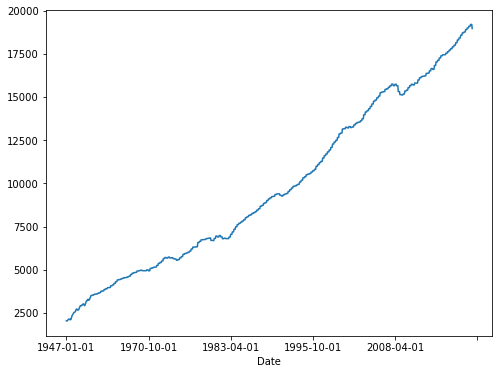

In [305]:
#Here we take a look at the historical gdp data

#A recession is defined as two consecutive quarterly declining gdp values

#It is important to note that the date is highly linear
#and the dips which conrespond to recessions are very shallow.

uni_data = df['GDPC1']
uni_data.index = df['Date']

uni_data.plot()

In [306]:
#Put gdp into an array
uni_data = uni_data.values

In [307]:
#Standardize and use ~90% of data for training
TRAIN_SPLIT = 880
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()
uni_data = (uni_data-uni_train_mean)/uni_train_std
#uni_data

In [308]:
##Data is windowed to create multiple time series from one time series

def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)


In [309]:
#At this time the ast history size is chosen so as to reduce validation error

tf.random.set_seed(7)

univariate_past_history = 24
univariate_future_target = 0


x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

#y_train_uni

In [280]:
#This is the first window
# print ('Single window of past history')
# print (x_train_uni[0])
# print ('\n Target gdp to predict')
# print (y_train_uni[0])

In [310]:
#The below functions will plot a window and show the value to predict

def create_time_steps(length):
  return list(range(-length, 0))

In [311]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

Text(0, 0.5, ' Standardized GDP')

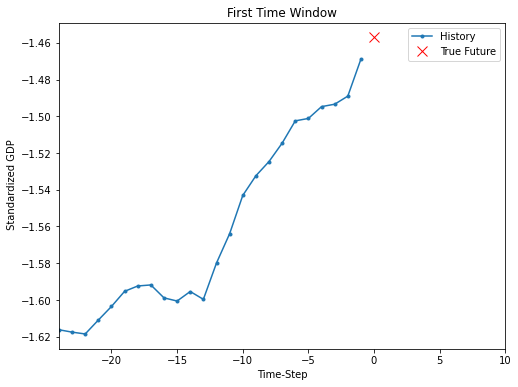

In [312]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'First Time Window')
plt.ylabel(' Standardized GDP')

In [313]:
#As a baseline comparison I consider a naive prediction of the
#previous value as the next value
y_pred= x_val_uni[:, -1]
np.mean(keras.losses.mean_squared_error(y_val_uni, y_pred))

#This gives a mse of 

0.048334774386389105

In [314]:
#This should help with training speed
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [315]:
#First try a simple RNN
model = keras.models.Sequential([
  keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

model.compile(optimizer= 'adam', loss= 'mae')


In [316]:
EVALUATION_INTERVAL = 500
EPOCHS = 10

model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=500)

Epoch 1/10
500/500 [==============================] - 4s 8ms/step - loss: 1.6916 - val_loss: 3.2235
Epoch 2/10
500/500 [==============================] - 4s 8ms/step - loss: 1.2543 - val_loss: 2.4217
Epoch 3/10
500/500 [==============================] - 4s 7ms/step - loss: 0.5876 - val_loss: 1.3142
Epoch 4/10
500/500 [==============================] - 4s 7ms/step - loss: 0.2392 - val_loss: 1.2698
Epoch 5/10
500/500 [==============================] - 4s 7ms/step - loss: 0.2285 - val_loss: 1.2643
Epoch 6/10
500/500 [==============================] - 4s 7ms/step - loss: 0.2232 - val_loss: 1.2595
Epoch 7/10
500/500 [==============================] - 4s 7ms/step - loss: 0.2179 - val_loss: 1.2553
Epoch 8/10
500/500 [==============================] - 4s 8ms/step - loss: 0.2128 - val_loss: 1.2516
Epoch 9/10
500/500 [==============================] - 4s 7ms/step - loss: 0.2079 - val_loss: 1.2486
Epoch 10/10
500/500 [==============================] - 4s 7ms/step - loss: 0.2033 - val_loss: 1.2462

<module 'matplotlib.pyplot' from 'c:\\users\\brady\\appdata\\local\\programs\\python\\python37\\lib\\site-packages\\matplotlib\\pyplot.py'>

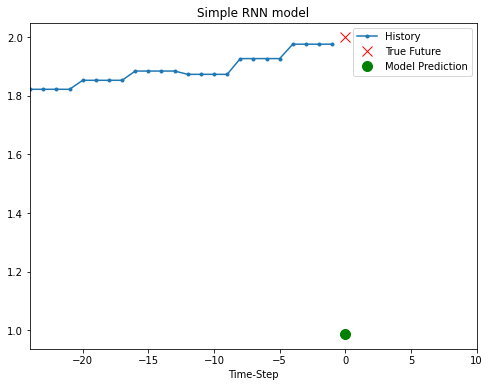

In [319]:
#This is not very good
#Could try more training or playing with val interval, epochs

show_plot([x[0].numpy(), y[0].numpy(),
                    model.predict(x)[0]], 0, 'Simple RNN model')


In [293]:
#This doesn't work yet
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

optimizer = keras.optimizers.Adam(lr=0.01)

y_train_uni.shape

(856,)

In [301]:
model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])

model.fit(x_train_uni, y_train_uni[:, 3::2], epochs=20,
                    validation_data=(x_val_uni, y_val_uni[:, 3::2]))

IndexError: too many indices for array

In [320]:
#Here we try a simply LSTM model

simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')


In [321]:
#This cell can be rerun multiple times to further train the model
EVALUATION_INTERVAL = 200
EPOCHS = 20

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/20
200/200 [==============================] - 2s 12ms/step - loss: 0.3375 - val_loss: 0.7650
Epoch 2/20
200/200 [==============================] - 2s 11ms/step - loss: 0.0191 - val_loss: 0.3252
Epoch 3/20
200/200 [==============================] - 2s 11ms/step - loss: 0.0123 - val_loss: 0.2648
Epoch 4/20
200/200 [==============================] - 2s 11ms/step - loss: 0.0114 - val_loss: 0.2198
Epoch 5/20
200/200 [==============================] - 2s 11ms/step - loss: 0.0108 - val_loss: 0.1836
Epoch 6/20
200/200 [==============================] - 2s 11ms/step - loss: 0.0102 - val_loss: 0.1608
Epoch 7/20
200/200 [==============================] - 2s 11ms/step - loss: 0.0098 - val_loss: 0.1450
Epoch 8/20
200/200 [==============================] - 2s 11ms/step - loss: 0.0095 - val_loss: 0.1288
Epoch 9/20
200/200 [==============================] - 2s 11ms/step - loss: 0.0092 - val_loss: 0.1167
Epoch 10/20
200/200 [==============================] - 2s 11ms/step - loss: 0.0089 - val_lo

<module 'matplotlib.pyplot' from 'c:\\users\\brady\\appdata\\local\\programs\\python\\python37\\lib\\site-packages\\matplotlib\\pyplot.py'>

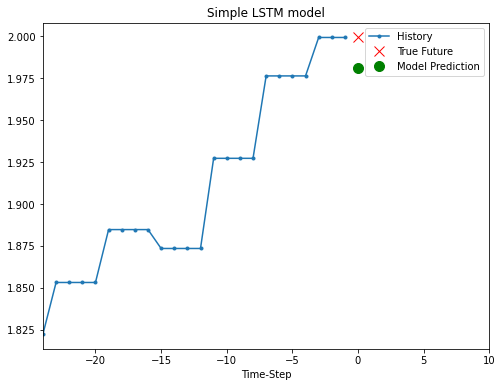

In [323]:
#This is a reasonable prediction and can imporove with more training
show_plot([x[3].numpy(), y[3].numpy(),
                     simple_lstm_model.predict(x)[3]], 0, 'Simple LSTM model')



In [324]:
#If you look at the data below you will see that there is no value that is lower than the previous value
#So it seems like the model is not able to predict the small dips at any time that would define a recession.

simple_lstm_model.predict(x)

array([[1.9610645],
       [1.9714259],
       [1.9777178],
       [1.9814259],
       [1.9834627],
       [1.9948577],
       [2.0021384],
       [2.0067368],
       [2.00957  ],
       [2.0207644],
       [2.0280552],
       [2.0326948],
       [2.0355914],
       [2.0414307],
       [2.045148 ],
       [2.0474012],
       [2.048715 ],
       [2.049794 ],
       [2.050343 ],
       [2.050558 ],
       [2.050584 ],
       [2.0567496],
       [2.0609992],
       [2.0638254],
       [2.0657177],
       [2.0726273],
       [2.0773413],
       [2.0804129],
       [2.0824082],
       [2.0900624],
       [2.095298 ],
       [2.0986953],
       [2.1009085],
       [2.108084 ],
       [2.113009 ],
       [2.1161892],
       [2.1182578],
       [2.1259198],
       [2.1312525],
       [2.1347182],
       [2.1370075],
       [2.1443043],
       [2.1494205],
       [2.1527426],
       [2.1549435],
       [2.1647317],
       [2.1717343],
       [2.1763237],
       [2.1794353],
       [2.1903546],


##Multivariate Forecast

In [326]:
#Here we will consider the historical gdp along with the 2 and 10 year federal funds rate
features_considered = ['DGS10Y', 'GDPC1', 'DGS2Y']

In [328]:
features = df[features_considered]
features.index = df['Date']

#Values before 1977 are dropped since some rates only go back that far
features= features.loc['1977-01-01 00:00:00':'2020-01-01 00:00:00']
#features

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001CC5EA75BC8>,
      dtype=object)

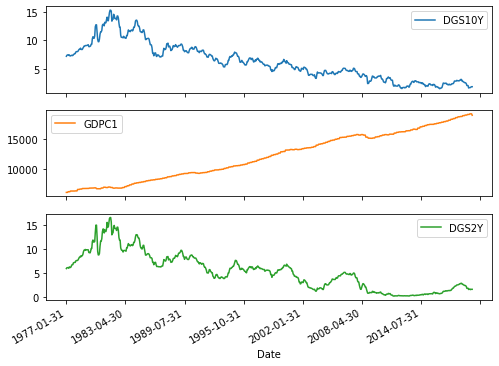

In [329]:
#Here we can look at our selected features
features.plot(subplots=True)

In [330]:
#First we try to predict a single point in the future using our three features

def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [332]:
TRAIN_SPLIT= 550
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

dataset = (dataset-data_mean)/data_std
dataset.shape

(688, 3)

In [333]:
past_history = 60
future_target = 8
STEP = 1

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)


#x_val_single

In [334]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [335]:
#Here we define our model
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')


In [336]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Epoch 1/10
200/200 [==============================] - 9s 47ms/step - loss: 0.0838 - val_loss: 0.5884
Epoch 2/10
200/200 [==============================] - 9s 43ms/step - loss: 0.0332 - val_loss: 0.5746
Epoch 3/10
200/200 [==============================] - 9s 45ms/step - loss: 0.0273 - val_loss: 0.5731
Epoch 4/10
200/200 [==============================] - 9s 44ms/step - loss: 0.0241 - val_loss: 0.5316
Epoch 5/10
200/200 [==============================] - 9s 46ms/step - loss: 0.0225 - val_loss: 0.5680
Epoch 6/10
200/200 [==============================] - 9s 45ms/step - loss: 0.0209 - val_loss: 0.5075
Epoch 7/10
200/200 [==============================] - 9s 44ms/step - loss: 0.0200 - val_loss: 0.5185
Epoch 8/10
200/200 [==============================] - 10s 50ms/step - loss: 0.0191 - val_loss: 0.4998
Epoch 9/10
200/200 [==============================] - 10s 49ms/step - loss: 0.0183 - val_loss: 0.5482
Epoch 10/10
200/200 [==============================] - 9s 47ms/step - loss: 0.0177 - val_

In [337]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

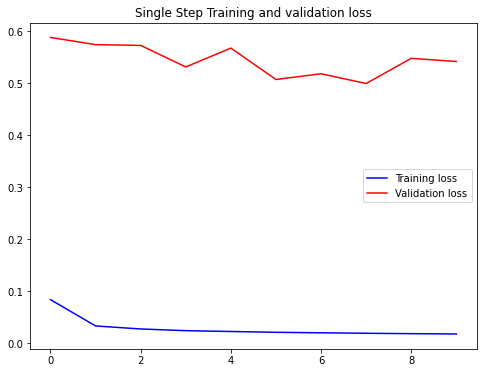

In [338]:
#The validaton loss is increasing which probably mean we are overfitting
#but nevertheless we are predicting far from the correct value
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

<module 'matplotlib.pyplot' from 'c:\\users\\brady\\appdata\\local\\programs\\python\\python37\\lib\\site-packages\\matplotlib\\pyplot.py'>

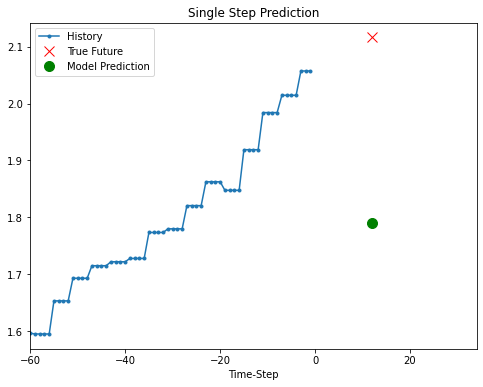

In [340]:
show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')


In [341]:
#Now we will attempt to predict 8 consecutive steps in the future
future_target = 8
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [342]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [343]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

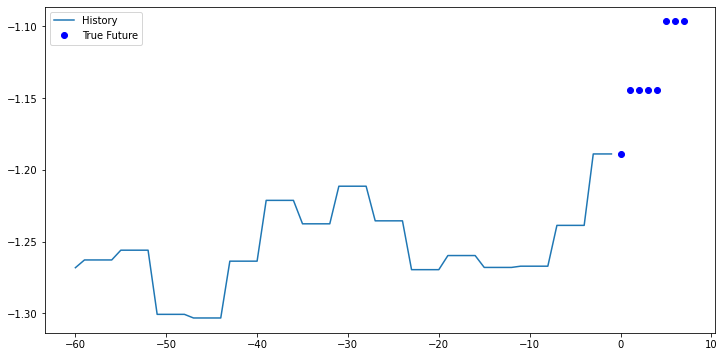

In [346]:
#I want to predict these values
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [347]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(8))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [348]:
EPOCHS= 20
EVALUATION_INTERVAL= 100

multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/20
100/100 [==============================] - 9s 85ms/step - loss: 0.2380 - val_loss: 0.5959
Epoch 2/20
100/100 [==============================] - 8s 82ms/step - loss: 0.0637 - val_loss: 0.8338
Epoch 3/20
100/100 [==============================] - 8s 80ms/step - loss: 0.0537 - val_loss: 0.8016
Epoch 4/20
100/100 [==============================] - 8s 80ms/step - loss: 0.0494 - val_loss: 0.8251
Epoch 5/20
100/100 [==============================] - 8s 83ms/step - loss: 0.0460 - val_loss: 0.8369
Epoch 6/20
100/100 [==============================] - 8s 78ms/step - loss: 0.0433 - val_loss: 0.7109
Epoch 7/20
100/100 [==============================] - 8s 79ms/step - loss: 0.0408 - val_loss: 0.6683
Epoch 8/20
100/100 [==============================] - 8s 79ms/step - loss: 0.0388 - val_loss: 0.7376
Epoch 9/20
100/100 [==============================] - 8s 78ms/step - loss: 0.0369 - val_loss: 0.7433
Epoch 10/20
100/100 [==============================] - 8s 78ms/step - loss: 0.0356 - val_lo

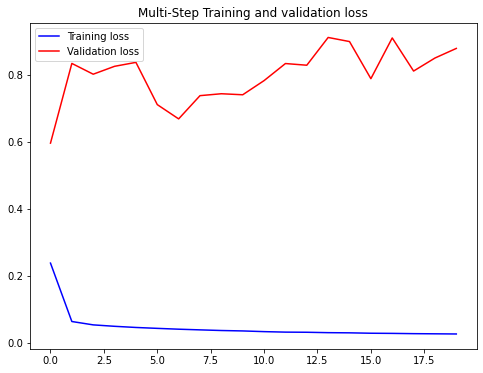

In [349]:
#Val loss increasing
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

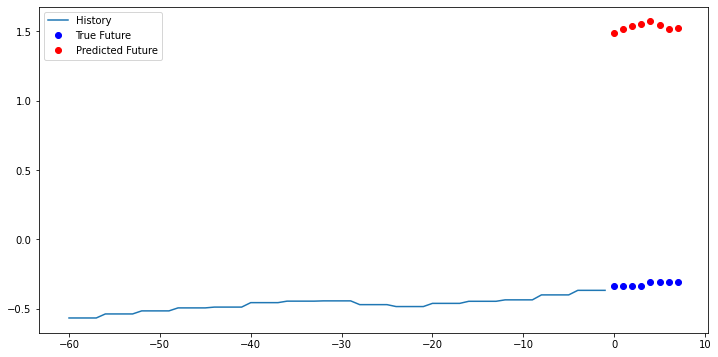

In [363]:
#Now this appears to be more accurate i some cases and not so accurate in others, 
#also there are some dips being predicted
#but I probably won't have time to include it in the results.

#Here we can see the prediction values
multi_step_plot(x[47], y[47], multi_step_model.predict(x)[252])

In [362]:
#Looking at some different window predictions, it seems like there are some recessions predicted
#however, at the moment there is no credibility attributed to the predictions
multi_step_model.predict(x)[252]

array([1.4900455, 1.5141311, 1.538632 , 1.5502238, 1.571598 , 1.5461127,
       1.5145655, 1.5250438], dtype=float32)